# Billboard Top 100

This dataset, available via Data.world, contains every weekly Hot 100 singles chart between 8/2/1958 and 12/28/2019 from Billboard.com. Each row of data represents a song and the corresponding position on that week's chart. Included in each row are the following elements:
1. Billboard Chart URL
2. WeekID
3. Song name
4. Performer name
5. SongID - Concatenation of song & performer
6. Current week on chart
7. Instance (this is used to separate breaks on the chart for a given song. Example, an instance of 6 tells you that this is the sixth time this song has appeared on the chart)
8. Previous week position
9. Peak Position (as of the corresponding week)
10. Weeks on Chart (as of the corresponding week)

Also available is a dataset containing each song's "audio features."

These include common attributes like genre as well as the following:
1. Danceability
2. Energy
3. Key
4. Loudness
5. Mode
6. Speechiness
7. Acousticness
8. Instrumentalness
9. Liveness
10. Valence
11. Tempo
12. Time Signature

Definitions of those terms are available at https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

Here's an example:

Liveliness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.



I'm excited about this data set. In addition to already numeric things like tempo, the ability to measure things like instrumentalness and speechiness give us some fun quantative measurements to play around with. I find change over time interesting, so I think I'm curious to see how things like average length of time on chart, average length of time on chart for #1 songs, and similar metrics change over time.

After exploring all that, I have a little bit of machine learning I'd like to do with this data set. First, I'd like to see what kind of clusters exist within some of the attributes available in the second data frame. Then I'm curious to see if I can use features from both dataframes to predict when a song originated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# 1: Explore the data
Let's just explore the data sets, do some cleaning/preprocessing, and get a sense of what's in there.

In [2]:
df1= pd.read_csv("Hot Stuff.csv")
print(len(df1))
print(df1.dtypes)
df1.head()

320495
url                        object
WeekID                     object
Week Position               int64
Song                       object
Performer                  object
SongID                     object
Instance                    int64
Previous Week Position    float64
Peak Position               int64
Weeks on Chart              int64
dtype: object


,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,http://www.billboard.com/charts/hot-100/1995-1...,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,http://www.billboard.com/charts/hot-100/1997-1...,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,http://www.billboard.com/charts/hot-100/2006-0...,7/1/2006,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,http://www.billboard.com/charts/hot-100/2009-1...,10/24/2009,1,3,Britney Spears,3Britney Spears,1,NaN,1,1


In [4]:
df1['WeekID']=pd.to_datetime(df1['WeekID'], infer_datetime_format=True) #Let's convert WeekID to a date, then we can use max functions to find the most recent WeekID

In [5]:
df1.isnull().sum()

url                           0
WeekID                        0
Week Position                 0
Song                          0
Performer                     0
SongID                        0
Instance                      0
Previous Week Position    30784
Peak Position                 0
Weeks on Chart                0
dtype: int64

This is actually a really clean set. Those missing Previous Week Position values are all from songs appearing on the chart for the first time and shouldn't have a value there. I'm going to tidy this data by defining an observation to be the number of weeks a song was on the chart, it's peak position, and it's final Week ID

In [6]:
df1['Song']

0                                          Poor Little Fool
1                                             One Sweet Day
2         Candle In The Wind 1997/Something About The Wa...
3                                       Do I Make You Proud
4                                                         3
                                ...                        
320490                                     Jingle Bell Rock
320491                                     Jingle Bell Rock
320492                                     Jingle Bell Rock
320493                                     Jingle Bell Rock
320494                                     Jingle Bell Rock
Name: Song, Length: 320495, dtype: object

In [7]:
df1[df1['Song'] == 'Jingle Bell Rock']

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
14317,http://www.billboard.com/charts/hot-100/1958-1...,1958-12-20,57,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,NaN,57,1
28510,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-09,71,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,NaN,71,1
85018,http://www.billboard.com/charts/hot-100/1958-1...,1958-12-27,35,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,57.0,35,2
85502,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-16,45,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,71.0,45,2
116000,http://www.billboard.com/charts/hot-100/1962-0...,1962-01-06,21,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,27.0,21,5
126618,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-23,27,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,45.0,27,3
127909,http://www.billboard.com/charts/hot-100/1959-0...,1959-01-03,45,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,35.0,35,3
177460,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-30,21,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,27.0,21,4
183140,http://www.billboard.com/charts/hot-100/1959-0...,1959-01-10,70,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,45.0,35,4
217855,http://www.billboard.com/charts/hot-100/1962-0...,1962-01-13,23,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,21.0,21,6


Hmm, a few occurences of Jingle Bell Rock. Let's see how many and when they appear.

In [8]:
df1[(df1['Song']=='Jingle Bell Rock')].sort_values(by='Weeks on Chart', ascending = False)

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
320494,https://www.billboard.com/charts/hot-100/2019-...,2019-12-28,9,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,15.0,9,29
320493,https://www.billboard.com/charts/hot-100/2019-...,2019-12-21,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,23.0,15,28
320492,https://www.billboard.com/charts/hot-100/2019-...,2019-12-14,23,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,47.0,23,27
320491,https://www.billboard.com/charts/hot-100/2019-...,2019-12-07,47,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,NaN,47,26
320490,https://www.billboard.com/charts/hot-100/2019-...,2019-01-05,8,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,13.0,8,25
320489,https://www.billboard.com/charts/hot-100/2018-...,2018-12-29,13,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,15.0,13,24
320488,https://www.billboard.com/charts/hot-100/2018-...,2018-12-22,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,26.0,15,23
320487,https://www.billboard.com/charts/hot-100/2018-...,2018-12-15,26,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,33.0,26,22
320486,https://www.billboard.com/charts/hot-100/2018-...,2018-12-08,33,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,NaN,33,21
320470,http://www.billboard.com/charts/hot-100/2017-0...,2017-01-07,29,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,6,46.0,29,20


So in addition to there being two different versions of Jingle Bell Rock, it looks like 'Weeks on Chart' allows for nonconsecutive weeks and 'Instance' tracks the nth time a song has entered the chart after having fallen off. Bobby Helms jumped from 1962 to 2016 and then showed up as recently as 2018. In a separate analysis, I might be interested in how Christmas music has changed over time. I could also use the point where Christmas music enters the chart to measure "Christmas Creep," the feeling that the Christmas season begins earlier each year.

In [9]:
df1[(df1['Song']=='Jingle Bell Rock') & (df1['Performer'] =='Bobby Helms')].sort_values(by='Weeks on Chart', ascending = False)

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
320494,https://www.billboard.com/charts/hot-100/2019-...,2019-12-28,9,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,15.0,9,29
320493,https://www.billboard.com/charts/hot-100/2019-...,2019-12-21,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,23.0,15,28
320492,https://www.billboard.com/charts/hot-100/2019-...,2019-12-14,23,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,47.0,23,27
320491,https://www.billboard.com/charts/hot-100/2019-...,2019-12-07,47,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,NaN,47,26
320490,https://www.billboard.com/charts/hot-100/2019-...,2019-01-05,8,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,13.0,8,25
320489,https://www.billboard.com/charts/hot-100/2018-...,2018-12-29,13,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,15.0,13,24
320488,https://www.billboard.com/charts/hot-100/2018-...,2018-12-22,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,26.0,15,23
320487,https://www.billboard.com/charts/hot-100/2018-...,2018-12-15,26,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,33.0,26,22
320486,https://www.billboard.com/charts/hot-100/2018-...,2018-12-08,33,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,NaN,33,21
320470,http://www.billboard.com/charts/hot-100/2017-0...,2017-01-07,29,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,6,46.0,29,20


I'm interested in seeing how the amount of time each song spends on the chart changes over time. So I'm going to make each chart it's own observation and then average the values in that chart. Now 'Weeks on Chart' will represent the average number of weeks each song on that chart has been on Billboard's top 100.

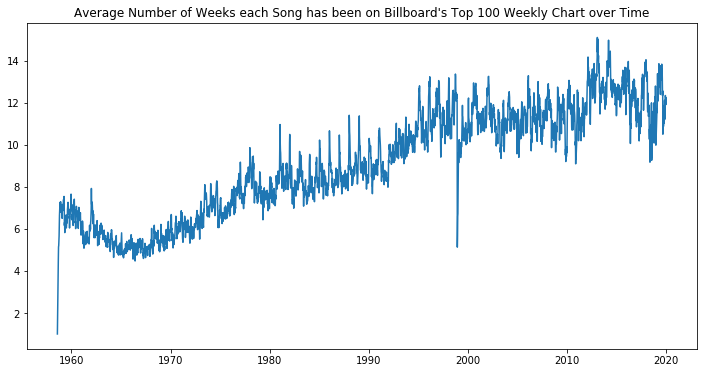

In [20]:
mean = df1.groupby('WeekID').mean().sort_values('WeekID', ascending=True)
#median = df1.groupby('WeekID').median().sort_values('WeekID', ascending=True)
#mean.head()
plt.figure(figsize=(12,6))
plt.title("Average Number of Weeks each Song has been on Billboard's Top 100 Weekly Chart over Time")
plt.plot(mean['Weeks on Chart']);

So there are a couple things we notice on this graph. First, there's that initial jump because the first few charts had no real values for "Weeks on Chart". 

Second, I'm quite surprised by the very clear upward trend!

Last, that dip just before 2000 is unusual. Let's zoom in around 1995-2000.

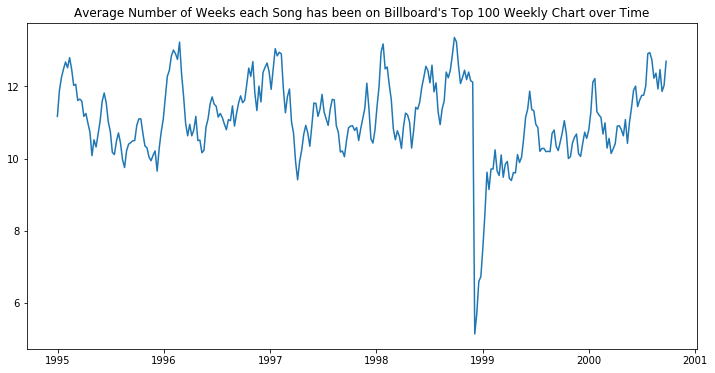

In [33]:
mean = df1.groupby('WeekID').mean().sort_values('WeekID', ascending=True)
#median = df1.groupby('WeekID').median().sort_values('WeekID', ascending=True)
#mean.head()
#mean_zoom = mean[(mean.iloc()) > 1995) & int((mean.iloc())<2000)]
plt.figure(figsize=(12,6))
plt.title("Average Number of Weeks each Song has been on Billboard's Top 100 Weekly Chart over Time")
plt.plot(mean[1900:2200]['Weeks on Chart']);

In [31]:
mean[2000:2200]

,Week Position,Instance,Previous Week Position,Peak Position,Weeks on Chart
WeekID,,,,,
1996-11-30,50.5,1.02,47.945055,38.82,11.57
1996-12-07,50.5,1.02,49.000000,37.01,12.39
1996-12-14,50.5,1.02,48.578947,37.36,12.53
1996-12-21,50.5,1.02,48.138298,37.53,12.65
1996-12-28,50.5,1.02,49.336842,37.91,12.41
...,...,...,...,...,...
2000-08-26,50.5,1.01,49.191489,40.43,11.93
2000-09-02,50.5,1.01,48.625000,38.94,12.47
2000-09-09,50.5,1.01,48.580645,41.02,11.86


I'd like to collapse the data so each song has a single entry on the chart including the last week it was on the chart, it's peak position, and the number of weeks spent on the chart.

In [10]:
new_df1 = df1.groupby('SongID').agg({'WeekID':'max', 'Peak Position':'min', 'Weeks on Chart':'max' })[['WeekID', 'Peak Position','Weeks on Chart']].reset_index()

In [11]:
print(new_df1.isnull().sum())
print(len(new_df1))
new_df1.head()

SongID            0
WeekID            0
Peak Position     0
Weeks on Chart    0
dtype: int64
28474


,SongID,WeekID,Peak Position,Weeks on Chart
0,"""B"" GirlsYoung And Restless",1990-08-11,54,15
1,"""Cherry Cherry"" from Hot August NightNeil Diamond",1973-05-19,31,10
2,"""Having A Party"" MedleyThe Ovations (Featuring...",1973-12-08,56,9
3,"""Joy"" Pt. IIsaac Hayes",1974-02-16,30,9
4,"""Roots"" MedleyQuincy Jones",1977-04-16,57,7


So, while we have quite a bit less of the dataframe, 28474 of the original 320k rows, we can start to look at some of the relationships between Peak Position and Weeks on Chart. I'd like to look at the mean and median time spent on the chart of a top 100 song and I'd also like to explore differences in those averages over time.

In [12]:
new_df1.sort_values('Weeks on Chart', ascending= False)

,SongID,WeekID,Peak Position,Weeks on Chart
18864,RadioactiveImagine Dragons,2014-05-10,3,87
19821,SailAWOLNATION,2014-03-22,17,79
11718,I'm YoursJason Mraz,2009-10-10,6,76
9827,How Do I LiveLeAnn Rimes,1998-10-10,2,69
18096,Party Rock AnthemLMFAO Featuring Lauren Bennet...,2012-07-21,1,68
...,...,...,...,...
6724,FallingHarry Styles,2019-12-28,62,1
23298,The Blacker The BerryKendrick Lamar,2015-04-04,66,1
11588,I'm MeLil Wayne,2008-02-16,97,1
26800,When You Dance I Can Really LoveNeil Young,1971-04-10,93,1


At first I was a little suspicious that a song spending 87 weeks on the chart wouldn't have made it all the way to # 1, but from Wikipedia's article on Radioactive by Imagine Dragons:

"...the song became a sleeper hit, peaking at number three on the US Billboard Hot 100 chart and becoming the band's first top 10 single as well as being the third best selling song in that country in 2013.[2] It also broke the record for slowest ascension to the top 5 in chart history[3] and currently holds the record for most weeks spent on the Billboard Hot 100 at 87 weeks."

count    2105.000000
mean       82.507838
std        17.880732
min         5.000000
25%        73.000000
50%        89.000000
75%        96.000000
max       100.000000
Name: Peak Position, dtype: float64


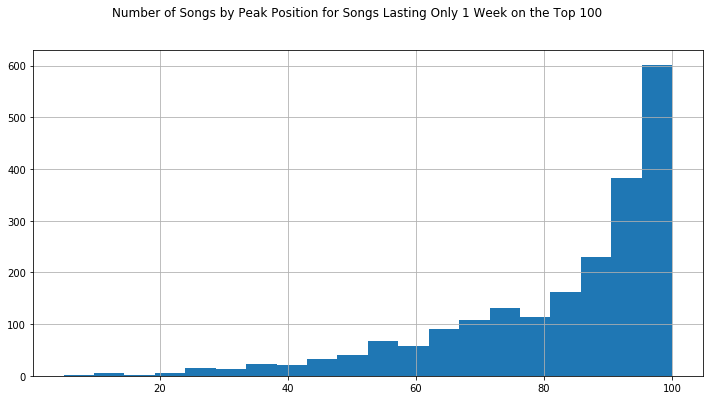

In [13]:
print(new_df1[new_df1['Weeks on Chart'] == 1]['Peak Position'].describe())
new_df1[new_df1['Weeks on Chart'] == 1]['Peak Position'].hist(bins=20, figsize=(12,6))
plt.suptitle( 'Number of Songs by Peak Position for Songs Lasting Only 1 Week on the Top 100');

count    28474.000000
mean        46.521283
std         30.589048
min          1.000000
25%         18.000000
50%         46.000000
75%         73.000000
max        100.000000
Name: Peak Position, dtype: float64


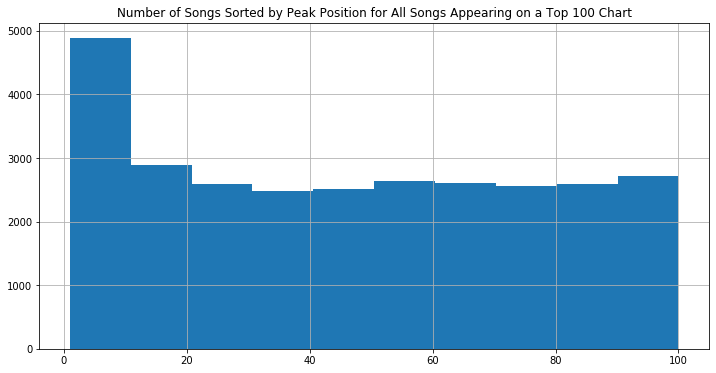

In [14]:
print(new_df1['Peak Position'].describe())
new_df1['Peak Position'].hist(bins=10, figsize=(12,6))
plt.title( 'Number of Songs Sorted by Peak Position for All Songs Appearing on a Top 100 Chart');

This is somewhat tricky to read. It seems counterintuitive that a Peak Position of 1-10 would account for so many more songs than any other bin, but those songs take up a ton of space throughout the chart both on their way up and down. Let's look at one of them.

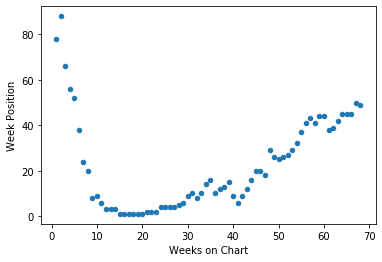

In [15]:
df1[df1['SongID']=='Party Rock AnthemLMFAO Featuring Lauren Bennett & GoonRock'].plot(kind='scatter', x='Weeks on Chart', y='Week Position');

We see that song is very high after about 15 weeks, stays there for 10 weeks or so, then spends weeks 25 to 70 working it's way off the chart.

Moving on, let's start to look at some of these things over time.

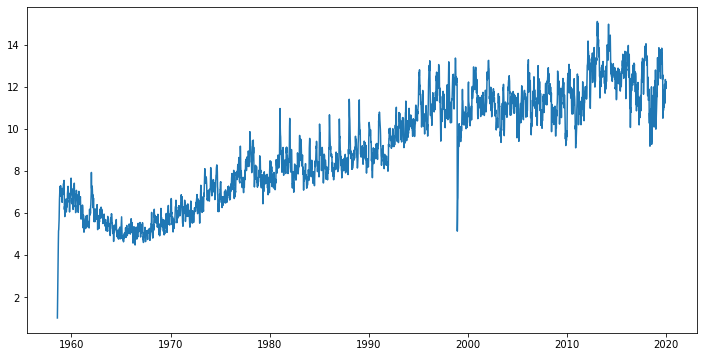

In [10]:
tryd = df1.groupby('WeekID').mean().sort_values('WeekID', ascending=True)
tryd.head()
plt.figure(figsize=(12,6))
plt.plot(tryd['Weeks on Chart']);

In [17]:
new_df1[new_df1['WeekID'] < datetime.datetime(1988,1,1)]['Weeks on Chart'].mean()


9.330364820046677

In [18]:
new_df1[new_df1['WeekID'] >= datetime.datetime(1988,1,1)]['Weeks on Chart'].mean()

13.835219816272966

So we notice prior to 1988, songs appearing on the top 100 spent an average of 9.33 weeks on the chart and songs appearing from 1988 and onward spent an average of 13.84 weeks on the top 100, nearly 50% more time on the chart! This is pretty counter to what I would've expected. Let's see if we can parse it out a bit more over 5 year intervals..

In [32]:


for i in range (0, 58):
    start_year = 1958+i
    end_year = 1963+i
    x=new_df1[(new_df1['WeekID'] >= datetime.datetime(start_year,1,1)) & (new_df1['WeekID'] <= datetime.datetime(end_year,1,1))]['Weeks on Chart'].mean()
    num_songs = len(new_df1[(new_df1['WeekID'] >= datetime.datetime(start_year,1,1)) & (new_df1['WeekID'] <= datetime.datetime(end_year,1,1))])
    print(num_songs, 'songs appeared on the top 100 charts from ', start_year, ' to ', end_year, ' and spent a mean of ', x, ' weeks on the chart.')

2757 songs appeared on the top 100 charts from  1958  to  1963  and spent a mean of  8.11860718171926  weeks on the chart.
3160 songs appeared on the top 100 charts from  1959  to  1964  and spent a mean of  8.226582278481013  weeks on the chart.
3312 songs appeared on the top 100 charts from  1960  to  1965  and spent a mean of  7.893417874396135  weeks on the chart.
3433 songs appeared on the top 100 charts from  1961  to  1966  and spent a mean of  7.594523740168948  weeks on the chart.
3491 songs appeared on the top 100 charts from  1962  to  1967  and spent a mean of  7.529934116299055  weeks on the chart.
3557 songs appeared on the top 100 charts from  1963  to  1968  and spent a mean of  7.336519538937306  weeks on the chart.
3574 songs appeared on the top 100 charts from  1964  to  1969  and spent a mean of  7.304700615556799  weeks on the chart.
3528 songs appeared on the top 100 charts from  1965  to  1970  and spent a mean of  7.3781179138322  weeks on the chart.
3452 songs 

In [76]:
for i in range (0, 12):
    start_year = 1958+5*i
    end_year = 1963+5*i
    x=new_df1[(new_df1['WeekID'] >= datetime.datetime(start_year,1,1)) & (new_df1['WeekID'] <= datetime.datetime(end_year,1,1))]['Weeks on Chart'].mean()
    num_songs = len(new_df1[(new_df1['WeekID'] >= datetime.datetime(start_year,1,1)) & (new_df1['WeekID'] <= datetime.datetime(end_year,1,1))])
    print(num_songs, 'songs appeared on the top 100 charts from ', start_year, ' to ', end_year, ' and spent a mean of ', x, ' weeks on the chart.')

2757 songs appeared on the top 100 charts from  1958  to  1963  and spent a mean of  8.11860718171926  weeks on the chart.
3557 songs appeared on the top 100 charts from  1963  to  1968  and spent a mean of  7.336519538937306  weeks on the chart.
3170 songs appeared on the top 100 charts from  1968  to  1973  and spent a mean of  8.18769716088328  weeks on the chart.
2553 songs appeared on the top 100 charts from  1973  to  1978  and spent a mean of  10.143360752056404  weeks on the chart.
2206 songs appeared on the top 100 charts from  1978  to  1983  and spent a mean of  11.778785131459655  weeks on the chart.
2043 songs appeared on the top 100 charts from  1983  to  1988  and spent a mean of  12.554576603034754  weeks on the chart.
1895 songs appeared on the top 100 charts from  1988  to  1993  and spent a mean of  13.903430079155672  weeks on the chart.
1638 songs appeared on the top 100 charts from  1993  to  1998  and spent a mean of  15.754578754578755  weeks on the chart.
1574 

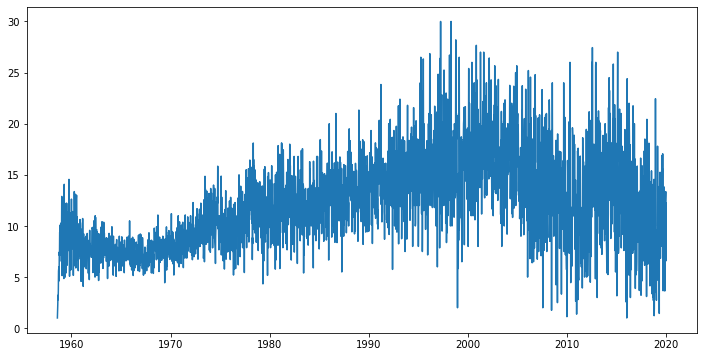

In [55]:
#df = new_df1.sort_values('WeekID', ascending=True)
#plt.plot(df['date'], df['count'])
#plt.xticks(rotation='vertical')

new = new_df1.groupby('WeekID').mean().sort_values('WeekID', ascending=True)
new.head()
plt.figure(figsize=(12,6))
plt.plot(new['Weeks on Chart']);

In [56]:
new_df1[new_df1['Peak Position'] == 1].sort_values('Weeks on Chart')

,SongID,WeekID,Peak Position,Weeks on Chart
9009,HeartlessThe Weeknd,2019-12-28,1,4
5288,Do I Make You ProudTaylor Hicks,2006-08-19,1,8
14633,Lose You To Love MeSelena Gomez,2019-12-28,1,9
3527,Can't Buy Me LoveThe Beatles,1964-05-30,1,10
6224,Eight Days A WeekThe Beatles,1965-04-24,1,10
...,...,...,...,...
1121,All Of MeJohn Legend,2014-12-06,1,59
21281,Somebody That I Used To KnowGotye Featuring Ki...,2013-03-02,1,59
15251,Macarena (Bayside Boys Mix)Los Del Rio,1997-02-08,1,60
19544,Rolling In The DeepAdele,2012-04-14,1,65


In [38]:
print('The median amount of time that a top 100 song song spends on the chart is', new_df1['Weeks on Chart'].median(), 'weeks')

The median amount of time that a top 100 song song spends on the chart is 10.0 weeks


In [39]:
print('The mean amount of time that a top 100 song spends on the chart is', new_df1['Weeks on Chart'].mean(), 'weeks')

The mean amount of time that a top 100 song spends on the chart is 11.259254056332093 weeks


9.330364820046677

13.835219816272966

In [11]:
df2 = pd.read_excel("Song_data.xlsx")
df2.head()

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),0.0,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,0.0,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,1.0,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,1.0,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In [36]:
df2.sort_values('SongID')

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
10308,"""B"" GirlsYoung And Restless",Young And Restless,"""B"" Girls",[],0rWUHulFlScxQsCq7kWKde,https://p.scdn.co/mp3-preview/c551cbcaadd17bf4...,Something To Get You Hyped,0.0,242106.0,20.0,...,7.0,-11.913,1.0,0.4390,0.0160,0.000000,0.3120,0.769,193.762,3.0
12928,"""Cherry Cherry"" from Hot August NightNeil Diamond",Neil Diamond,"""Cherry Cherry"" from Hot August Night","['adult standards', 'brill building pop', 'fol...",18ocy9Be9SxWEEnOLGDfkS,NaN,Hot August Night / NYC (Live From Madison Squa...,0.0,443320.0,16.0,...,9.0,-5.061,1.0,0.1370,0.0941,0.000907,0.8670,0.604,172.349,4.0
19355,"""Having A Party"" MedleyThe Ovations (Featuring...",The Ovations (Featuring Louis Williams),"""Having A Party"" Medley","['memphis soul', 'southern soul']",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11563,"""Joy"" Pt. IIsaac Hayes",Isaac Hayes,"""Joy"" Pt. I","['classic soul', 'disco', 'funk', 'jazz funk',...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19935,"""Roots"" MedleyQuincy Jones",Quincy Jones,"""Roots"" Medley","['adult standards', 'disco', 'funk', 'jazz fun...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6128,teachmeMusiq Soulchild,Musiq Soulchild,teachme,"['alternative r&b', 'dance pop', 'neo soul', '...",0ODFPypnJLE6hKgahiuSzn,https://p.scdn.co/mp3-preview/0a49d387a7ecc54d...,Luvanmusiq,0.0,260017.0,57.0,...,8.0,-5.110,0.0,0.1350,0.4730,0.000000,0.0722,0.436,172.969,3.0
25353,whoa (mind in awe)XXXTENTACION,XXXTENTACION,whoa (mind in awe),"['emo rap', 'miami hip hop']",7pdF27mSDuPWhppnHAmWHa,https://p.scdn.co/mp3-preview/f69b47e8941ef8f4...,SKINS,0.0,157776.0,77.0,...,6.0,-2.939,0.0,0.0441,0.6530,0.918000,0.1010,0.369,160.147,4.0
25358,whoknowsMusiq,Musiq,whoknows,"['alternative r&b', 'dance pop', 'neo soul', '...",69rOfKSz0ys8UdgTkGd6qV,NaN,soulstar,0.0,295320.0,39.0,...,2.0,-6.144,1.0,0.1220,0.2300,0.000000,0.3390,0.316,118.862,4.0
25845,www.memoryAlan Jackson,Alan Jackson,www.memory,"['contemporary country', 'country', 'country r...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df2.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

I can use 'SongID' to join the dataframes. I'd like to clean the genre information up a bit. I don't need to keep the spotify information, but I want everything from danceability to time_signature.

### Work on next time:

df1: construct df and plot averages over time
     test for significance

df2:
    expand genre column
    remove columns
    join data
    deal with missing information
    look for trends in numeric values
    